In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from textblob import TextBlob

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
init_data = pd.read_csv("winemag-data-130k-v2.csv")
init_data = init_data.drop(init_data.columns[0], axis=1)
print("Length of dataframe before duplicates are removed:", len(init_data))
init_data.sample(5)

Length of dataframe before duplicates are removed: 129971


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
79132,New Zealand,A bit restrained—or might that be muted?—on th...,NaN,84,11.0,East Coast,NaN,NaN,Joe Czerwinski,@JoeCz,Monkey Bay 2006 Chardonnay (East Coast),Chardonnay,Monkey Bay
113180,France,"A well-balanced rich wine, showing the ripe fr...",Domaine de Riaz,88,NaN,Beaujolais,Côte de Brouilly,NaN,Roger Voss,@vossroger,Georges Duboeuf 2009 Domaine de Riaz (Côte de...,Gamay,Georges Duboeuf
34056,US,All varietal coming from Dwelley and Minnick H...,Winemaker's Select,88,42.0,Washington,Walla Walla Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Adamant Cellars 2012 Winemaker's Select Merlot...,Merlot,Adamant Cellars
28658,US,"Deep, dark espresso bean, loam and graphite ar...",NaN,85,19.0,California,Monterey County,Central Coast,Matt Kettmann,@mattkettmann,Las Palmeras 2013 Cabernet Sauvignon (Monterey...,Cabernet Sauvignon,Las Palmeras
52236,Austria,Tangy orange zest and lime are the dominant fl...,NaN,87,NaN,Burgenland,NaN,NaN,Roger Voss,@vossroger,Höpler 2012 Grüner Veltliner (Burgenland),Grüner Veltliner,Höpler


In [3]:
data = init_data.copy()
data.drop_duplicates(subset='description', inplace=True)
print("Length of dataframe after duplicates are removed:", len(data))

data = data.dropna(subset=['description', 'price', 'points', 'country', 'variety'])
print("Length of dataframe after NaNs are removed:", len(data))

Length of dataframe after duplicates are removed: 119955
Length of dataframe after NaNs are removed: 111511


In [4]:
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111511 entries, 0 to 111510
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                111511 non-null  object 
 1   description            111511 non-null  object 
 2   designation            79472 non-null   object 
 3   points                 111511 non-null  int64  
 4   price                  111511 non-null  float64
 5   province               111511 non-null  object 
 6   region_1               93556 non-null   object 
 7   region_2               46559 non-null   object 
 8   taster_name            88244 non-null   object 
 9   taster_twitter_handle  83761 non-null   object 
 10  title                  111511 non-null  object 
 11  variety                111511 non-null  object 
 12  winery                 111511 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 11.1+ MB


In [5]:
def transform_points_simplified(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 5

data = data.assign(points_simplified = data['points'].apply(transform_points_simplified))
data.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points_simplified
71750,US,Has its work cut out for it. Fundamentally a o...,Estate De Cascabel Vineyard,82,18.0,California,Fair Play,Sierra Foothills,NaN,NaN,Oakstone 1999 Estate De Cascabel Vineyard Cabe...,Cabernet Sauvignon,Oakstone,1
67984,US,This aromatic barrel selection employs multipl...,Jory Hills Vineyard,91,55.0,Oregon,Dundee Hills,Willamette Valley,Paul Gregutt,@paulgwine,WillaKenzie Estate 2014 Jory Hills Vineyard Pi...,Pinot Noir,WillaKenzie Estate,3
1861,Italy,This gorgeous Greco di Tufo opens with bright ...,NaN,88,25.0,Southern Italy,Greco di Tufo,NaN,NaN,NaN,Mastroberardino 2011 Greco di Tufo,Greco,Mastroberardino,3
56270,US,Fresh cut pear drizzled with lemon juice is gi...,NaN,91,36.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Daou 2013 Grenache Blanc (Paso Robles),Grenache Blanc,Daou,3
10216,Italy,"A blend of Sangiovese and 20% Canaiolo, it con...",NaN,86,22.0,Tuscany,Rosso di Montepulciano,NaN,Kerin O’Keefe,@kerinokeefe,La Calonica 2012 Rosso di Montepulciano,Red Blend,La Calonica,2


### Explore features

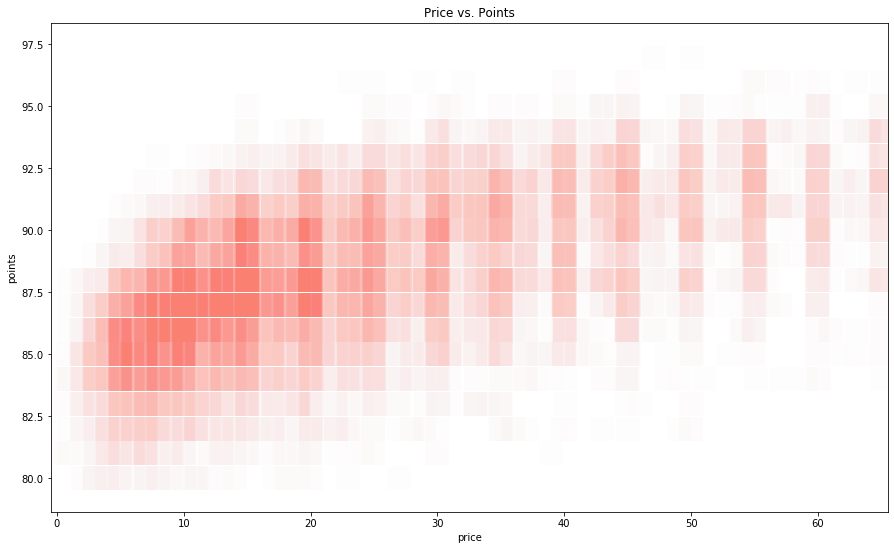

In [34]:
plt.figure(figsize=(15,9))
price_plot = sns.stripplot(x='price',
                           y='points',
                           data=data[data['price']<=70].sample(10000),
                           size=24,
                           marker='s',
                           alpha=0.01,
                           color='salmon')
price_plot.set_title('Price vs. Points')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))

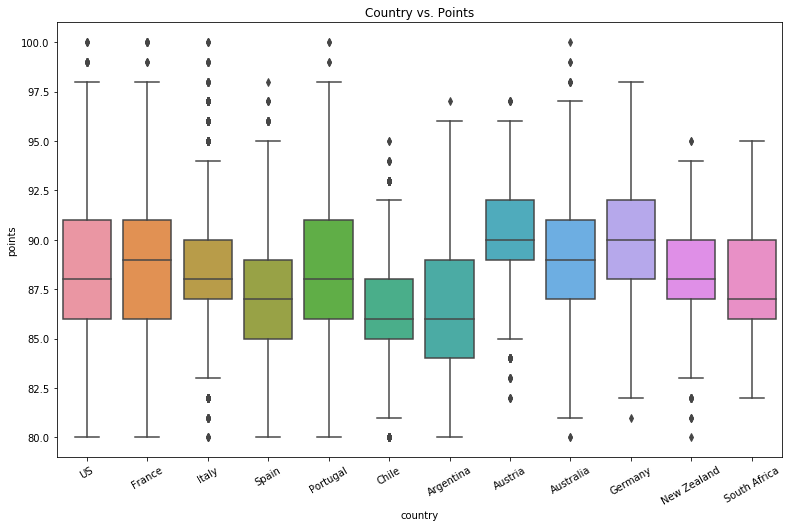

In [35]:
plt.figure(figsize=(13,8))
country_plot = sns.boxplot(x='country',
                           y='points',
                           data=data,
                           order=['US', 'France', 'Italy', 'Spain', 'Portugal', 
                                  'Chile', 'Argentina', 'Austria', 'Australia',
                                  'Germany', 'New Zealand', 'South Africa']
                          )
country_plot.set_title('Country vs. Points');
country_plot.set_xticklabels(country_plot.get_xticklabels(), rotation=30);

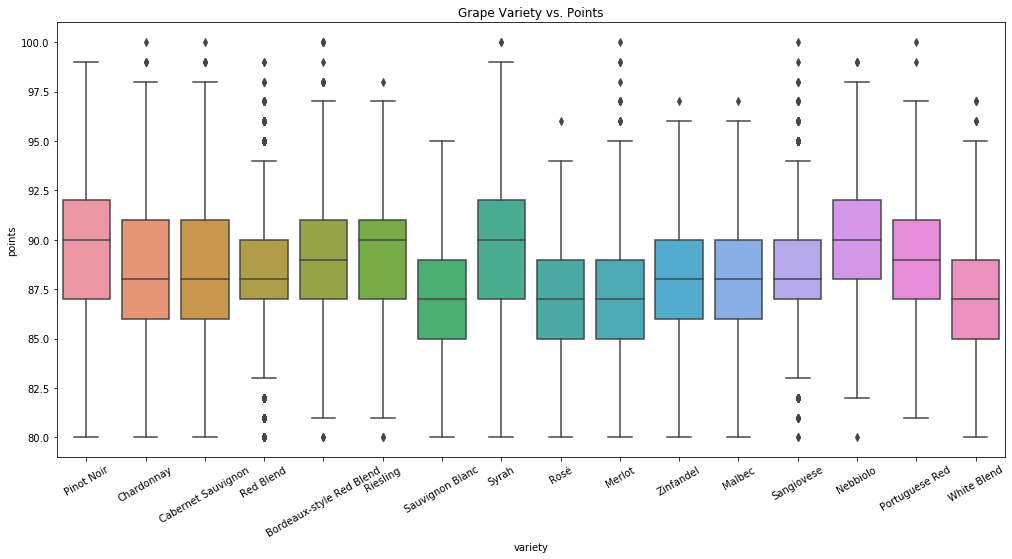

In [36]:
plt.figure(figsize=(17,8))
variety_plot = sns.boxplot(x='variety',
                           y='points',
                           data=data,
                           order=['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 
                                  'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 
                                  'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot',
                                  'Zinfandel', 'Malbec', 'Sangiovese', 'Nebbiolo',
                                  'Portuguese Red', 'White Blend']
                          )
variety_plot.set_title('Grape Variety vs. Points');
variety_plot.set_xticklabels(variety_plot.get_xticklabels(), rotation=30);

In [119]:
data['polarity'] = data['description'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['description'].astype(str).apply(len)
data['word_count'] = data['description'].apply(lambda x: len(str(x).split()))

In [120]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = data.loc[data.polarity == 1, ['description']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

This blend of 88% Cabernet Sauvignon and 12% Cabernet Franc is rustic smelling, with a rubbery, tannic mouthfeel and flavors of roasted plum and berry. Let this wine aerate to show its best.
The name “Salvarenza” comes from a legend in which a damsel, Renza, needed to be saved, “salva,” from imminent danger. This vineyard cru expression shows wonderful intensity of peach, melon and citrus aromas and would pair with asparagus flan and cheese sauce.
From a single-walled vineyard, this is a ripe, generous and still structured cru wine. It has layers of delicious black-plum fruits and a jammy ripe texture that cushions the tannins. The vineyard is wholly owned by Edouard Labruyère, making it a monopole. Drink from 2018.
Made from 90% Chardonnay, the remainder Pinot Gris, this light-golden sparkler is well-composed, with a maturity on the palate leaning towards flavors of almond and anise. Floral and creamy, it has buoyant aci

Text(0.5, 1.0, 'Polarity')

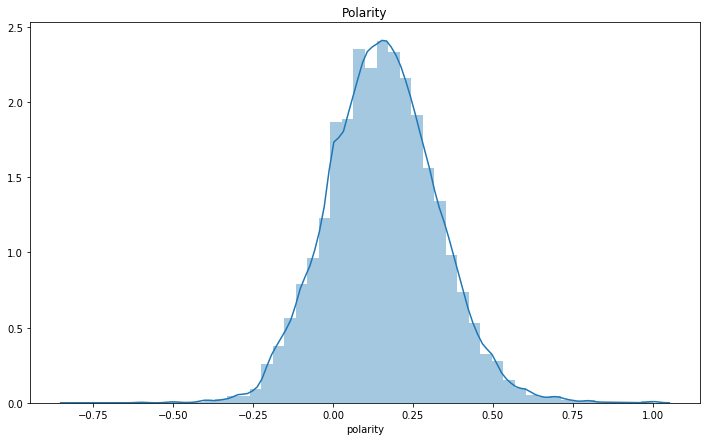

In [121]:
plt.figure(figsize=(12,7))
polarity_plot = sns.distplot(data['polarity'])
polarity_plot.set_title('Polarity')

Text(0.5, 1.0, 'Length of Review')

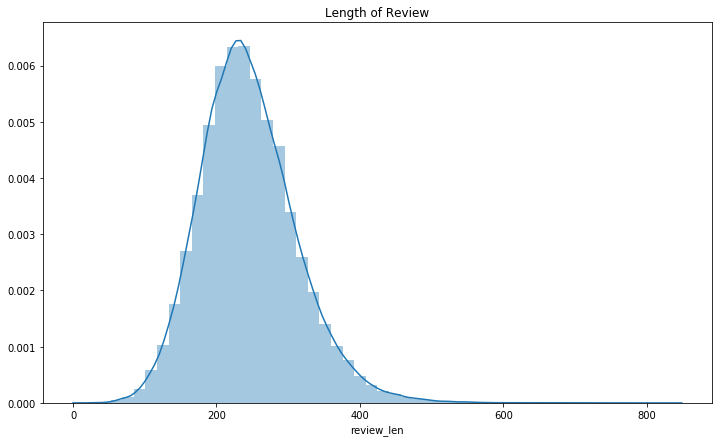

In [132]:
plt.figure(figsize=(12,7))
review_length_plot = sns.distplot(data['review_len'])
review_length_plot.set_title('Length of Review')

In [126]:
X_text = data['description']
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(stop_words = 'english').fit(X_text)
    bag_of_words = vec.transform(X_text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['description'], 20)

top_word_count = pd.DataFrame(common_words, columns = ['word' , 'count'])

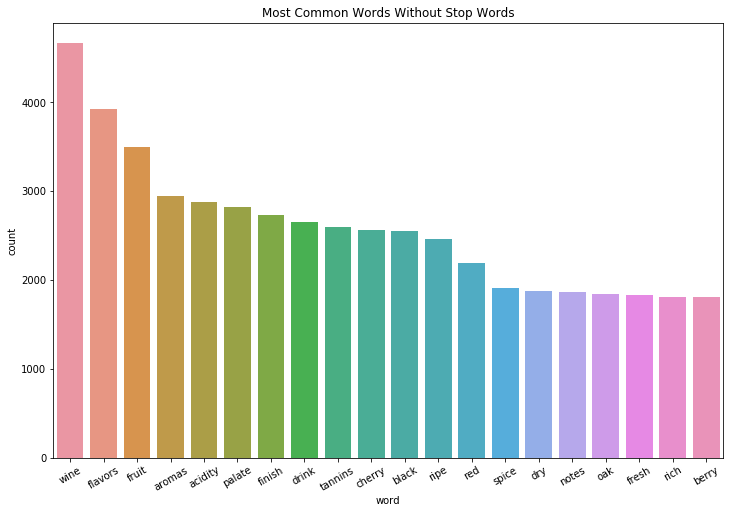

In [133]:
plt.figure(figsize=(12,8))
top_word_count_plot = sns.barplot(x='word', y='count', data=top_word_count)
top_word_count_plot.set_title('Most Common Words Without Stop Words')
top_word_count_plot.set_xticklabels(top_word_count_plot.get_xticklabels(), rotation=30);

### Use non-text features for prediction

In [6]:
features = ['price', 'country', 'province', 'variety', 'winery']
X = data[features]
y = data['points_simplified']

numerical_cols = list((X.columns[X.dtypes=='int64']) | (X.columns[X.dtypes=='float64']))
categorical_cols = list(X.columns[X.dtypes=='object'])

In [7]:
numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols), 
                                               ('obj', categorical_transformer, categorical_cols)])

In [126]:
rf_model = RandomForestClassifier()
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rf_model', rf_model)])

scoring = ['precision_macro', 'recall_macro', 'f1_macro',
           'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(rf_pipeline, X, y, scoring=scoring)
k = len(scores['test_precision_macro'])
print('test_precision_macro:    ' + str(sum(scores['test_precision_macro']) / k))
print('test_recall_macro:       ' + str(sum(scores['test_recall_macro']) / k))
print('test_f1_macro:           ' + str(sum(scores['test_f1_macro']) / k))
print('test_precision_weighted: ' + str(sum(scores['test_precision_weighted']) / k))
print('test_recall_weighted:    ' + str(sum(scores['test_recall_weighted']) / k))
print('test_f1_weighted:        ' + str(sum(scores['test_f1_weighted']) / k))

test_precision_macro:    0.44575999985258086
test_recall_macro:       0.3999015942369561
test_f1_macro:           0.41466144193410265
test_precision_weighted: 0.5536211268268463
test_recall_weighted:    0.5631462482946322
test_f1_weighted:        0.5563066178658447


In [127]:
xgb_model = XGBClassifier()
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgb_model', xgb_model)])

scoring = ['precision_macro', 'recall_macro', 'f1_macro',
           'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(xgb_pipeline, X, y, scoring=scoring)
k = len(scores['test_precision_macro'])
print('test_precision_macro:    ' + str(sum(scores['test_precision_macro']) / k))
print('test_recall_macro:       ' + str(sum(scores['test_recall_macro']) / k))
print('test_f1_macro:           ' + str(sum(scores['test_f1_macro']) / k))
print('test_precision_weighted: ' + str(sum(scores['test_precision_weighted']) / k))
print('test_recall_weighted:    ' + str(sum(scores['test_recall_weighted']) / k))
print('test_f1_weighted:        ' + str(sum(scores['test_f1_weighted']) / k))

/Users/maxpeng/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxpeng/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxpeng/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test_precision_macro:    0.41445293009151996
test_recall_macro:       0.34087449488251265
test_f1_macro:           0.34325622720325183
test_precision_weighted: 0.5441218435368932
test_recall_weighted:    0.5673969624048546
test_f1_weighted:        0.5463015924418592


/Users/maxpeng/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Use text for prediction

In [135]:
X_text = data['description']
y = data['points_simplified']

vectorizer = TfidfVectorizer()
vectorizer.fit(X_text)
X_text = vectorizer.transform(X_text)

In [12]:
rf_model_text = RandomForestClassifier()

scoring = ['precision_macro', 'recall_macro', 'f1_macro',
           'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(rf_model_text, X_text, y, scoring=scoring)
k = len(scores['test_precision_macro'])
print('test_precision_macro:    ' + str(sum(scores['test_precision_macro']) / k))
print('test_recall_macro:       ' + str(sum(scores['test_recall_macro']) / k))
print('test_f1_macro:           ' + str(sum(scores['test_f1_macro']) / k))
print('test_precision_weighted: ' + str(sum(scores['test_precision_weighted']) / k))
print('test_recall_weighted:    ' + str(sum(scores['test_recall_weighted']) / k))
print('test_f1_weighted:        ' + str(sum(scores['test_f1_weighted']) / k))

test_precision_macro:    0.5738998915078161
test_recall_macro:       0.33906758754057537
test_f1_macro:           0.3406265672587864
test_precision_weighted: 0.6397098078440204
test_recall_weighted:    0.6061734408982671
test_f1_weighted:        0.5649945369202835


In [13]:
lr_model_text = LogisticRegression()

scoring = ['precision_macro', 'recall_macro', 'f1_macro',
           'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(lr_model_text, X_text, y, scoring=scoring)
k = len(scores['test_precision_macro'])
print('test_precision_macro:    ' + str(sum(scores['test_precision_macro']) / k))
print('test_recall_macro:       ' + str(sum(scores['test_recall_macro']) / k))
print('test_f1_macro:           ' + str(sum(scores['test_f1_macro']) / k))
print('test_precision_weighted: ' + str(sum(scores['test_precision_weighted']) / k))
print('test_recall_weighted:    ' + str(sum(scores['test_recall_weighted']) / k))
print('test_f1_weighted:        ' + str(sum(scores['test_f1_weighted']) / k))

test_precision_macro:    0.5893773590943224
test_recall_macro:       0.4661776707185994
test_f1_macro:           0.4930066381392659
test_precision_weighted: 0.6667761798264847
test_recall_weighted:    0.6670194528924487
test_f1_weighted:        0.659404930698896


In [17]:
nb_model_text = MultinomialNB()

scoring = ['precision_macro', 'recall_macro', 'f1_macro',
           'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(nb_model_text, X_text, y, scoring=scoring)
k = len(scores['test_precision_macro'])
print('test_precision_macro:    ' + str(sum(scores['test_precision_macro']) / k))
print('test_recall_macro:       ' + str(sum(scores['test_recall_macro']) / k))
print('test_f1_macro:           ' + str(sum(scores['test_f1_macro']) / k))
print('test_precision_weighted: ' + str(sum(scores['test_precision_weighted']) / k))
print('test_recall_weighted:    ' + str(sum(scores['test_recall_weighted']) / k))
print('test_f1_weighted:        ' + str(sum(scores['test_f1_weighted']) / k))

test_precision_macro:    0.5448269417532543
test_recall_macro:       0.311030729490229
test_f1_macro:           0.2922357703408517
test_precision_weighted: 0.6266861683035221
test_recall_weighted:    0.5927667026404219
test_f1_weighted:        0.5340632884181303


### Fine tune logistic regression

In [36]:
lr_model_text = LogisticRegression(max_iter=1000, C=10)

scoring = ['precision_macro', 'recall_macro', 'f1_macro',
           'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(lr_model_text, X_text, y, scoring=scoring)
k = len(scores['test_precision_macro'])
print('test_precision_macro:    ' + str(sum(scores['test_precision_macro']) / k))
print('test_recall_macro:       ' + str(sum(scores['test_recall_macro']) / k))
print('test_f1_macro:           ' + str(sum(scores['test_f1_macro']) / k))
print('test_precision_weighted: ' + str(sum(scores['test_precision_weighted']) / k))
print('test_recall_weighted:    ' + str(sum(scores['test_recall_weighted']) / k))
print('test_f1_weighted:        ' + str(sum(scores['test_f1_weighted']) / k))

test_precision_macro:    0.6018753995914256
test_recall_macro:       0.4956889961724501
test_f1_macro:           0.5204250707249468
test_precision_weighted: 0.6601282137862583
test_recall_weighted:    0.6626431854832381
test_f1_weighted:        0.6585331625659869


### Get most informative features

In [136]:
lr_model_text = LogisticRegression(max_iter=1000, C=10)
lr_model_text.fit(X_text, y)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(lr_model_text.coef_[0], feature_names)) 
coef_word=pd.DataFrame(coefs_with_fns)
coef_word.columns='coefficient','word'
most_positive_words = coef_word.sort_values(by='coefficient', ascending=True).head(10)
least_positive_words = coef_word.sort_values(by='coefficient', ascending=False).head(10)

In [142]:
display(most_positive_words)
display(least_positive_words)

,coefficient,word
0,-11.070877,rich
1,-10.546012,delicious
2,-9.466781,long
3,-8.817528,years
4,-8.427545,perfectly
5,-8.377941,complex
6,-7.559031,elegant
7,-7.223915,great
8,-7.223200,vineyard
9,-7.088023,power


,coefficient,word
30249,8.477426,simple
30248,8.004244,lacks
30247,7.062340,thin
30246,6.452477,watery
30245,5.977336,dull
30244,5.648097,harsh
30243,5.399635,acceptable
30242,5.268235,mealy
30241,5.153666,bitter
30240,5.150535,burgers


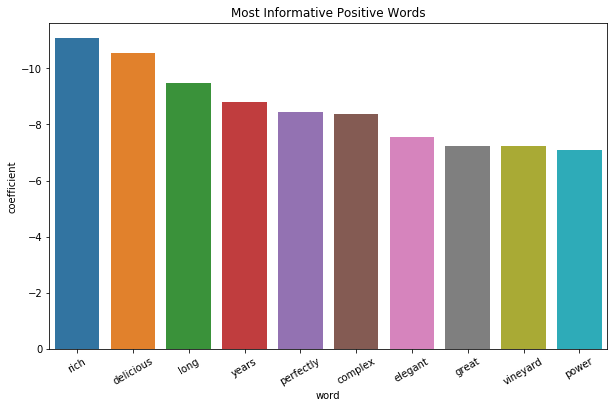

In [147]:
plt.figure(figsize=(10,6))
most_positive_plot = sns.barplot(x='word', y='coefficient', data=most_positive_words)
most_positive_plot.set_title('Most Informative Positive Words')
most_positive_plot.set_xticklabels(most_positive_plot.get_xticklabels(), rotation=30)
plt.ylim(reversed(plt.ylim()));

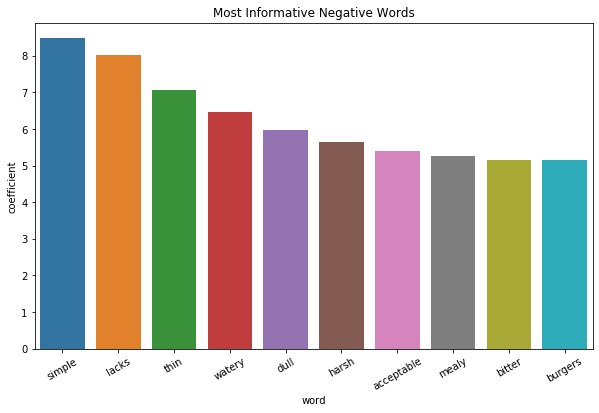

In [148]:
plt.figure(figsize=(10,6))
least_positive_plot = sns.barplot(x='word', y='coefficient', data=least_positive_words)
least_positive_plot.set_title('Most Informative Negative Words')
least_positive_plot.set_xticklabels(least_positive_plot.get_xticklabels(), rotation=30);